# Miniproject: Image Classification

### Description

One of the oldest traditions in deep learning is to first tackle the fun problem of MNIST classification. [The MNIST dataset](https://en.wikipedia.org/wiki/MNIST_database) is a large database of handwritten digits that is commonly used as a first test for new classification algorithms. 
We follow this tradition to investigate the performance of artificial neural networks of different complexity on MNIST. However, since MNIST is too easy for accessing the full power of modern machine learning algorithms (see e.g. [this post](https://twitter.com/goodfellow_ian/status/852591106655043584)) we will extend our analysis to the recently introduced, harder [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist).

### Prerequisites

- You should have a running installation of [tensorflow](https://www.tensorflow.org/install/) and [keras](https://keras.io/). Feel free to gain inspiration from the [Keras example directory](https://keras.io/examples/) for your implementations.
- You should know the concepts "multilayer perceptron", "stochastic gradient descent with minibatches", "Adam", "convolutional neural network", "training and validation data", "overfitting", "regularization", and "early stopping".

### What you will learn

- You will learn how to define feedforward neural networks in keras and fit them to data (i.e. training).
- You will be guided through a prototyping procedure for the application of deep learning to a specific domain.
- You will gain some experience on the influence of network architecture, optimizer and regularization choices on the goodness of fit.
- You will learn to be more patient :) Some fits may take your computer quite a bit of time; run them over night (or on an external server).

### Evaluation criteria

The evaluation is (mostly) based on the figures you submit and your answer sentences. Provide clear and concise answers respecting the indicated maximum length.

**The submitted notebook must be run by you!** We will only do random tests of your code and not re-run the full notebook. There will be fraud detection sessions at the end of the semester.

### Your names

**Before you start**: please enter your full name(s) in the field below.

In [ ]:
student1 = "Xiaoqi Ma"
student2 = "Anqi Hou"

## Some helper functions

For your convenience we provide here some functions to preprocess the data and plot the results later. Simply run the following cells with `Shift-Enter`.

### Dependencies and constants

In [2]:
%matplotlib inline

import numpy as np
import time
import matplotlib.pyplot as plt
import scipy.io
import tensorflow as tf

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization, Activation
from keras.optimizers import SGD, Adam
from keras import regularizers
from keras import optimizers
from keras.callbacks import EarlyStopping
from keras import utils as np_utils


np.random.seed(0)
tf.random.set_seed(0)

### Plotting

In [3]:
def plot_some_samples(x, y = [], yhat = [], select_from = [], 
                      ncols = 6, nrows = 4, xdim = 28, ydim = 28,
                      label_mapping = range(10)):
    """plot some input vectors as grayscale images (optionally together with their assigned or predicted labels).
    
    x is an NxD - dimensional array, where D is the length of an input vector and N is the number of samples.
    Out of the N samples, ncols x nrows indices are randomly selected from the list select_from (if it is empty, select_from becomes range(N)).
    """
    fig, ax = plt.subplots(nrows, ncols)
    if len(select_from) == 0:
        select_from = range(x.shape[0])
    indices = np.random.choice(select_from, size = min(ncols * nrows, len(select_from)), replace = False)
    for i, ind in enumerate(indices):
        thisax = ax[i//ncols,i%ncols]
        thisax.matshow(x[ind].reshape(xdim, ydim), cmap='gray')
        thisax.set_axis_off()
        if len(y) != 0:
            j = y[ind] if type(y[ind]) != np.ndarray else y[ind].argmax()
            thisax.text(0, 0, (label_mapping[j]+1)%10, color='green', 
                                                       verticalalignment='top',
                                                       transform=thisax.transAxes)
        if len(yhat) != 0:
            k = yhat[ind] if type(yhat[ind]) != np.ndarray else yhat[ind].argmax()
            thisax.text(1, 0, (label_mapping[k]+1)%10, color='red',
                                             verticalalignment='top',
                                             horizontalalignment='right',
                                             transform=thisax.transAxes)
    return fig

def prepare_standardplot(title, xlabel):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(title)
    ax1.set_ylabel('categorical cross entropy')
    ax1.set_xlabel(xlabel)
    ax1.set_yscale('log')
    ax2.set_ylabel('accuracy [% correct]')
    ax2.set_xlabel(xlabel)
    return fig, ax1, ax2

def finalize_standardplot(fig, ax1, ax2):
    ax1handles, ax1labels = ax1.get_legend_handles_labels()
    if len(ax1labels) > 0:
        ax1.legend(ax1handles, ax1labels)
    ax2handles, ax2labels = ax2.get_legend_handles_labels()
    if len(ax2labels) > 0:
        ax2.legend(ax2handles, ax2labels)
    fig.tight_layout()
    plt.subplots_adjust(top=0.9)

def plot_history(history, title):
    fig, ax1, ax2 = prepare_standardplot(title, 'epoch')
    ax1.plot(history.history['loss'], label = "train")
    ax1.plot(history.history['val_loss'], label = "val")
    ax2.plot(history.history['accuracy'], label = "train")
    ax2.plot(history.history['val_accuracy'], label = "val")
    finalize_standardplot(fig, ax1, ax2)
    return fig

## Exercise 1: Data import and visualization (6 points)

The datasets we use in this project (MNIST, Fashion-MNIST) consists of grayscale images with 28x28 pixels. 
The low resolution (and grayscale) of the images certainly misses some information that could be helpful for classifying the images. However, since the data has lower dimensionality due to the low resolution, the training converges faster. This is an advantage in situations like here (or generally when prototyping), where we want to try many different things without having to wait too long. 

1. As a warm-up exercise, use the importer to (down-)load the MNIST and Fashion-MNIST dataset. Assign useful variables to test & train images and labels for both datasets respectively. (2 pts)
2. Use the function `plot_some_samples` defined above to plot some samples of the two datasets. What do the green digits at the bottom left of each image indicate? (2 pts)
3. To prepare for training: 1. transform the labels to one hot coding, i.e. for 5 classes, label 2 becomes the vector [0, 0, 1, 0, 0] (you can use `utils.to_categorical` function from keras), and 2. reshape (flatten) the input images to input vectors and rescale the input data into the range [0,1]. (2 pts)

*Hint*: Keras comes with a convenient in-built [data importer](https://keras.io/datasets/) for common datasets. 

**Answer to Question 2** (1 sentence):

> The green digits are the labels mapping to the corresponding images.



### Solution

#### 1-1

In [4]:
# exercise1-1: downloads data at first execution
from keras.datasets import mnist
from keras.datasets import fashion_mnist 

# downloads the MNIST train images/labels and test images/labels
(x_mnist_train, y_mnist_train), (x_mnist_test, y_mnist_test) = mnist.load_data()

# downloads the fashion MNIST train images/labels and test images/labels
(x_fashion_train, y_fashion_train), (x_fashion_test, y_fashion_test) = fashion_mnist.load_data()

#### 1-2

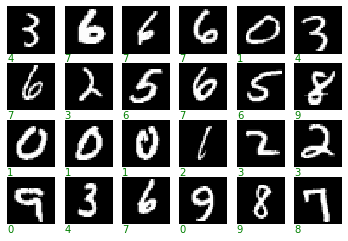

In [5]:
#exercise1-2: plot samples of mnist train data
plot_some_samples(x_mnist_train, y_mnist_train);

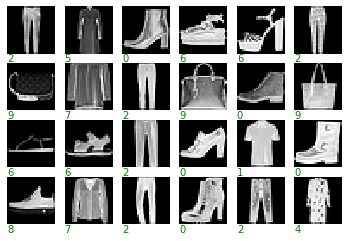

In [6]:
#exercise1-2: plot samples of fashion-mnist train data
plot_some_samples(x_fashion_train, y_fashion_train);

#### 1-3

In [7]:
#exercise1-3:transform the labels to one hot coding
from tensorflow.keras.utils import to_categorical

labels_mnist_train = to_categorical(y_mnist_train)
labels_mnist_test = to_categorical(y_mnist_test)

labels_fashion_train = to_categorical(y_fashion_train)
labels_fashion_test = to_categorical(y_fashion_test)

print("The shape of the labels of MNIST train data in one hot coding:", labels_mnist_train.shape)

The shape of the labels of MNIST train data in one hot coding: (60000, 10)


In [8]:
# function that rescale the input data to [0,1]
def normalization(data):
    data.astype('float32')
    x=(data-np.min(data))/(np.max(data)-np.min(data))
    return x

In [9]:
#exercise1-3: reshape and rescale the input data(images)
data_mnist_train =normalization(x_mnist_train.reshape(x_mnist_train.shape[0], -1))
data_mnist_test=normalization(x_mnist_test.reshape(x_mnist_test.shape[0], -1))

data_fashion_train=normalization(x_fashion_train.reshape(x_fashion_train.shape[0], -1))
data_fashion_test=normalization(x_fashion_test.reshape(x_fashion_test.shape[0], -1))

print("The shape of  MNIST train data after reshaping and rescaling:", data_mnist_train.shape)

The shape of  MNIST train data after reshaping and rescaling: (60000, 784)


## Exercise 2: No hidden layer (10 points)

Define and fit a model without a hidden layer (since we will use multi-layer models later in this project, you can define a general constructor function for models with an arbitrary number of hidden layers already at this point). Note that in this miniproject there is no real test dataset and what is loaded as a test dataset is used for validation. First, implement 1.-3. for the MNIST dataset.  

1. Implement the model with the following specifications: use the softmax activation for the output layer, use the categorical_crossentropy loss, choose stochastic gradient descent for the optimizer, and add the accuracy metric to the metrics. (5 pts)
2. Train for as many epochs as needed to see no further decrease in the validation loss. (1 pt)
3. Plot the learning curves resulting from the fitting procedure (a history object) using the function `plot_history` defined above. (1 pt)
4. Repeat the above steps for fitting the network to the Fashion-MNIST dataset. (2 pts)
5. Report the best validation accuracy achieved for each one of the datasets. Do you observe overfitting already for this simple model? Answer separetely for the MNIST dataset and Fashion-MNIST dataset. (1 pt) 

*Hint:* Read the keras docs, in particular [Getting started with the Keras Sequential model](https://keras.io/getting-started/sequential-model-guide/).

**Answer to Question 5** (max 2 sentences): 

The best validation accuracy achieved for MNIST is 0.9255, for Fashion-MNIST is 0.8469. 

In this simple sample, we don't observe overfitting for both datasets.



### Solution

#### 2-1

In [ ]:
## model for MNIST data
np.random.seed(0)
tf.random.set_seed(0)

# Question 2-1: Implement the model 
model2_MNIST = Sequential()
model2_MNIST.add(Dense(10, activation='softmax'))
model2_MNIST.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

#### 2-2

In [ ]:
# Question 2-2: train for the model 
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)
history2_MNIST=model2_MNIST.fit(data_mnist_train, labels_mnist_train, batch_size=128, epochs=500, validation_data=(data_mnist_test,labels_mnist_test), verbose=1, callbacks=[es])

Epoch 1/500
469/469 [==============================] - 2s 3ms/step - loss: 1.6278 - accuracy: 0.5438 - val_loss: 0.8108 - val_accuracy: 0.8319
Epoch 2/500
469/469 [==============================] - 1s 2ms/step - loss: 0.7621 - accuracy: 0.8317 - val_loss: 0.6079 - val_accuracy: 0.8601
Epoch 3/500
469/469 [==============================] - 1s 2ms/step - loss: 0.6131 - accuracy: 0.8540 - val_loss: 0.5259 - val_accuracy: 0.8729
Epoch 4/500
469/469 [==============================] - 1s 2ms/step - loss: 0.5363 - accuracy: 0.8655 - val_loss: 0.4802 - val_accuracy: 0.8815
Epoch 5/500
469/469 [==============================] - 1s 2ms/step - loss: 0.4922 - accuracy: 0.8751 - val_loss: 0.4501 - val_accuracy: 0.8865
Epoch 6/500
469/469 [==============================] - 1s 2ms/step - loss: 0.4700 - accuracy: 0.8780 - val_loss: 0.4288 - val_accuracy: 0.8894
Epoch 7/500
469/469 [==============================] - 1s 2ms/step - loss: 0.4454 - accuracy: 0.8825 - val_loss: 0.4126 - val_accuracy: 0.8924

#### 2-3

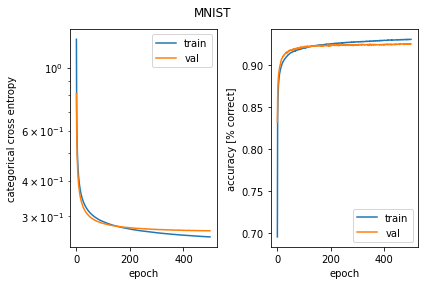

In [ ]:
#Question 2-3: plot history for MNIST data
plot_history(history2_MNIST, 'MNIST');

In [ ]:
# print the best validation accuracy achieved.
a= max(history2_MNIST.history['val_accuracy'])
print('The best validation accuracy is:', str(round(a, 4)))

The best validation accuracy is: 0.9255


#### 2-4

In [ ]:
## model for Fashion-MNIST data
np.random.seed(0)
tf.random.set_seed(0)

# Question 2-4: Implement the model 
model2_fashion_MNIST = Sequential()
model2_fashion_MNIST .add(Dense(10, activation='softmax'))
model2_fashion_MNIST .compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

# Question 2-4: train for the model 
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)
history2_fashion=model2_fashion_MNIST.fit(data_fashion_train, labels_fashion_train, batch_size=128, epochs=500, validation_data=(data_fashion_test,labels_fashion_test), verbose=1, callbacks=[es])

Epoch 1/500
469/469 [==============================] - 8s 2ms/step - loss: 1.5025 - accuracy: 0.5440 - val_loss: 0.8686 - val_accuracy: 0.7175
Epoch 2/500
469/469 [==============================] - 1s 2ms/step - loss: 0.8154 - accuracy: 0.7394 - val_loss: 0.7457 - val_accuracy: 0.7530
Epoch 3/500
469/469 [==============================] - 1s 2ms/step - loss: 0.7101 - accuracy: 0.7754 - val_loss: 0.6881 - val_accuracy: 0.7739
Epoch 4/500
469/469 [==============================] - 1s 2ms/step - loss: 0.6583 - accuracy: 0.7895 - val_loss: 0.6532 - val_accuracy: 0.7841
Epoch 5/500
469/469 [==============================] - 1s 2ms/step - loss: 0.6251 - accuracy: 0.7996 - val_loss: 0.6275 - val_accuracy: 0.7920
Epoch 6/500
469/469 [==============================] - 1s 2ms/step - loss: 0.6000 - accuracy: 0.8077 - val_loss: 0.6102 - val_accuracy: 0.7967
Epoch 7/500
469/469 [==============================] - 1s 2ms/step - loss: 0.5807 - accuracy: 0.8110 - val_loss: 0.5947 - val_accuracy: 0.8031

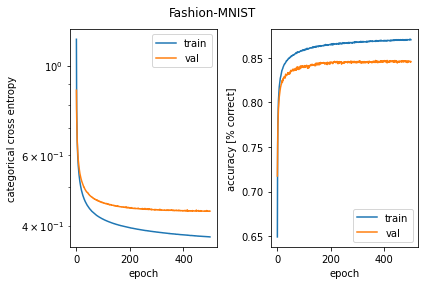

In [ ]:
#Question 2-4: plot history for Fashion-MNIST data
plot_history(history2_fashion, 'Fashion-MNIST');

In [ ]:
# print the best validation accuracy achieved.
a= max(history2_fashion.history['val_accuracy'])
print('The best validation accuracy is:', str(round(a, 4)))

The best validation accuracy is: 0.8469


## Exercise 3: One hidden layer, different optimizers (10 points)

Train a network with one hidden layer and compare different optimizers for the MNIST dataset.

1. Use one hidden layer with 128 units and the 'relu' activation. Use the [summary method](https://keras.io/api/models/model/#summary-method) to display your model in a compact way. (1 pt)
2. Train the model for at least 50 epochs with different learning rates of stochastic gradient descent (SGD). What happens if the learning rate $\eta$ is very large (for ex. $\eta=1$), and very small (for ex. $\eta=0.001$)? Comment on the fluctuations of the learning curve. (2 pts)
3. Replace the stochastic gradient descent optimizer with the [Adam optimizer](https://keras.io/optimizers/#adam) (you can use the default learning rate). (1pt)
4. Plot the learning curves of SGD with a good learning rate (i.e. in the range [0.01,0.1]) together with the learning curves of Adam in the same figure. Take care of a reasonable labeling of the curves in the plot. (1 pts)
5. Explain the qualitative difference between the loss and accuracy curves with respect to signs of overfitting. Report the best validation accuracy achieved for SGD and Adam. Which one is better and why do you think so? (2 pts)
6. Determine the indices of all test images that are misclassified by the fitted model and plot some of them using the function 
   `plot_some_samples`. (1 pt)

Real-world datasets are labeled by some people and sometimes there are mistakes in the labeling. We will corrupt labels of the MNIST dataset artifically, and observe an overfitting to this noisy dataset with Adam. 

7. Take $ p = 0.2 $ fraction of the data points from the training dataset of MNIST and change their class labels randomly. (You can sample a random integer from 0 to 9 using `np.random.uniform` and `np.floor`). Train with Adam for 50 or 100 epochs. Plot the learning curves. Do you observe overfitting in the validation accuracy? Does it take longer to converge to perfect training accuracy compare to noise-free MNIST? (2 pts)

**Answer to Question 2** (max 2 sentences): 

Within 50 epochs, $\eta=1$ reaches a higher validation accuracy than $\eta=0.001$. 

We observed quite obvious  fluctuatations in both validation loss and validation accuracy curves when $\eta=1$, but when $\eta=0.001$, we observed quite smooth curve in both validation loss and validation accuracy garphs. 

**Answer to Question 5** (max 3 sentences): 

With the same learning rate, for Adam optimizer the signs of overfitting appears at the very beginning of 50 epochs and the accuracy curve converges quickly as well, but we don't see a sign of overfitting for the SGD optimizer within 50 epochs. 

Within 50 epochs, the best validation accuracy achieved for SGD is 0.9717, for Adam is 0.9677.

The SGD is better, because it has a higher validation accuracy, and its loss and accuracy curves are smooth, whereas the sign of overfitting is so obvious with Adam and loss and accuracy curves of both test and validation dataset fluctuate heavily.

**Answer to Question 7** (max 2 sentences): 

We observe overfitting in the validation accuracy. 

It takes longer to converge to perfect training accuracy compare to noise-free MNIST.

### Solution

#### 3-1

In [ ]:
#Question 3-1: implement and summary the model
model3_minist = Sequential()
model3_minist.add(Dense(128, input_dim = 784, activation='relu'))
model3_minist.add(Dense(10, activation='softmax'))
model3_minist.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


#### 3-2

In [ ]:
#Question 3-2: train the model with SGD for learning rate 1

np.random.seed(0)
tf.random.set_seed(0)

model3_sgd_1 = Sequential()
model3_sgd_1.add(Dense(128, input_dim = 784, activation='relu'))
model3_sgd_1.add(Dense(10, activation='softmax'))
opt=optimizers.SGD(lr = 1)
model3_sgd_1.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])
history3_sgd_1 = model3_sgd_1.fit(data_mnist_train, labels_mnist_train, batch_size = 128, epochs = 50, validation_data=(data_mnist_test,labels_mnist_test), verbose=1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/50
469/469 [==============================] - 2s 3ms/step - loss: 0.8619 - accuracy: 0.7433 - val_loss: 0.1722 - val_accuracy: 0.9476
Epoch 2/50
469/469 [==============================] - 1s 3ms/step - loss: 0.1481 - accuracy: 0.9550 - val_loss: 0.1679 - val_accuracy: 0.9489
Epoch 3/50
469/469 [==============================] - 1s 3ms/step - loss: 0.1143 - accuracy: 0.9648 - val_loss: 0.1267 - val_accuracy: 0.9604
Epoch 4/50
469/469 [==============================] - 1s 3ms/step - loss: 0.0915 - accuracy: 0.9729 - val_loss: 0.1122 - val_accuracy: 0.9673
Epoch 5/50
469/469 [==============================] - 1s 3ms/step - loss: 0.0743 - accuracy: 0.9777 - val_loss: 0.1203 - val_accuracy: 0.9644
Epoch 6/50
469/469 [==============================] - 1s 3ms/step - loss: 0.0638 - accuracy: 0.9806 - val_loss: 0.1129 - val_accuracy: 0.9680
Epoch 7/50
469/469 [==============================] - 1s 3ms/step - loss: 0.0577 - accuracy: 0.9817 - val_loss: 0.1062 - val_accuracy: 0.9689
Epoch 

In [ ]:
#Question 3-2: train the model with SGD for learning rate 0.001
np.random.seed(0)
tf.random.set_seed(0)

model3_sgd_0001= Sequential()
model3_sgd_0001.add(Dense(128, input_dim = 784, activation='relu'))
model3_sgd_0001.add(Dense(10, activation='softmax'))
opt=optimizers.SGD(learning_rate = 0.001)
model3_sgd_0001.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])
history3_sgd_0001 = model3_sgd_0001.fit(data_mnist_train, labels_mnist_train, batch_size = 128, epochs = 50, validation_data=(data_mnist_test,labels_mnist_test), verbose=1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/50
469/469 [==============================] - 2s 3ms/step - loss: 2.2249 - accuracy: 0.1808 - val_loss: 1.8995 - val_accuracy: 0.5008
Epoch 2/50
469/469 [==============================] - 1s 3ms/step - loss: 1.8243 - accuracy: 0.5428 - val_loss: 1.5702 - val_accuracy: 0.6587
Epoch 3/50
469/469 [==============================] - 1s 3ms/step - loss: 1.5241 - accuracy: 0.6683 - val_loss: 1.3118 - val_accuracy: 0.7320
Epoch 4/50
469/469 [==============================] - 1s 3ms/step - loss: 1.2802 - accuracy: 0.7317 - val_loss: 1.1164 - val_accuracy: 0.7756
Epoch 5/50
469/469 [==============================] - 1s 3ms/step - loss: 1.1043 - accuracy: 0.7687 - val_loss: 0.9722 - val_accuracy: 0.8027
Epoch 6/50
469/469 [==============================] - 1s 3ms/step - loss: 0.9747 - accuracy: 0.7910 - val_loss: 0.8656 - val_accuracy: 0.8177
Epoch 7/50
469/469 [==============================] - 1s 3ms/step - loss: 0.8684 - accuracy: 0.8125 - val_loss: 0.7848 - val_accuracy: 0.8329
Epoch 

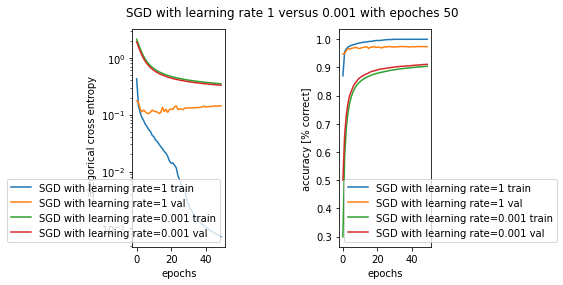

In [ ]:
# Question 3-2: plot the learning curves of sgd with lr=1 or lr=0.001
def comparison_lr_plot(history_lr1, history_lr2, label1, label2, title):
    fig, ax1, ax2 = prepare_standardplot(title, "epochs")
    ax1.plot(history_lr1.history['loss'], label=label1 + ' train')
    ax1.plot(history_lr1.history['val_loss'], label=label1 + ' val')
    ax1.plot(history_lr2.history['loss'], label=label2 + ' train')
    ax1.plot(history_lr2.history['val_loss'], label=label2 + ' val')
    ax2.plot(history_lr1.history['accuracy'], label=label1 + ' train')
    ax2.plot(history_lr1.history['val_accuracy'], label=label1 + ' val')
    ax2.plot(history_lr2.history['accuracy'], label=label2 + ' train')
    ax2.plot(history_lr2.history['val_accuracy'], label=label2 + ' val')
    finalize_standardplot(fig, ax1, ax2)
    return fig

comparison_lr_plot(history3_sgd_1, history3_sgd_0001, 'SGD with learning rate=1', 'SGD with learning rate=0.001', 'SGD with learning rate 1 versus 0.001 with epoches 50');

#### 3-3

In [ ]:
#Question 3-3: train the model with SGD for learning rate 0.02

np.random.seed(0)
tf.random.set_seed(0)

model3_sgd_002 = Sequential()
model3_sgd_002.add(Dense(128, input_dim = 784, activation='relu'))
model3_sgd_002.add(Dense(10, activation='softmax'))
sgd = optimizers.SGD(learning_rate = 0.02)
model3_sgd_002.compile(optimizer = sgd, loss = 'categorical_crossentropy', metrics = ['accuracy'])
history3_sgd_002 = model3_sgd_002.fit(data_mnist_train, labels_mnist_train, batch_size = 128, epochs = 50, validation_data=(data_mnist_test,labels_mnist_test), verbose=1)

Epoch 1/50
469/469 [==============================] - 2s 4ms/step - loss: 1.3544 - accuracy: 0.6410 - val_loss: 0.4590 - val_accuracy: 0.8838
Epoch 2/50
469/469 [==============================] - 1s 3ms/step - loss: 0.4378 - accuracy: 0.8846 - val_loss: 0.3560 - val_accuracy: 0.9043
Epoch 3/50
469/469 [==============================] - 1s 3ms/step - loss: 0.3664 - accuracy: 0.8978 - val_loss: 0.3147 - val_accuracy: 0.9125
Epoch 4/50
469/469 [==============================] - 1s 3ms/step - loss: 0.3253 - accuracy: 0.9089 - val_loss: 0.2908 - val_accuracy: 0.9193
Epoch 5/50
469/469 [==============================] - 1s 3ms/step - loss: 0.2942 - accuracy: 0.9186 - val_loss: 0.2746 - val_accuracy: 0.9232
Epoch 6/50
469/469 [==============================] - 1s 3ms/step - loss: 0.2813 - accuracy: 0.9212 - val_loss: 0.2585 - val_accuracy: 0.9275
Epoch 7/50
469/469 [==============================] - 1s 3ms/step - loss: 0.2625 - accuracy: 0.9258 - val_loss: 0.2455 - val_accuracy: 0.9314
Epoch 

In [ ]:
# print the best validation accuracy achieved by SGD.
a= max(history3_sgd_002.history['val_accuracy'])
print('The best validation accuracy achieved by SGD is:', str(round(a, 4)))

The best validation accuracy achieved by SGD is: 0.9717


In [ ]:
#Question 3-3: train the model with Adam for learning rate 0.02

np.random.seed(0)
tf.random.set_seed(0)

model_adam_002 = Sequential()
model_adam_002.add(Dense(128, input_dim = 784, activation='relu'))
model_adam_002.add(Dense(10, activation='softmax'))
adam = optimizers.Adam(learning_rate = 0.02)
model_adam_002.compile(optimizer=adam, loss = 'categorical_crossentropy', metrics = ['accuracy'])
history_adam_002 = model_adam_002.fit(data_mnist_train, labels_mnist_train, batch_size = 128, epochs = 50, validation_data=(data_mnist_test,labels_mnist_test), verbose=1)

Epoch 1/50
469/469 [==============================] - 2s 4ms/step - loss: 0.3961 - accuracy: 0.8809 - val_loss: 0.1603 - val_accuracy: 0.9521
Epoch 2/50
469/469 [==============================] - 1s 3ms/step - loss: 0.1464 - accuracy: 0.9575 - val_loss: 0.1477 - val_accuracy: 0.9577
Epoch 3/50
469/469 [==============================] - 1s 3ms/step - loss: 0.1289 - accuracy: 0.9633 - val_loss: 0.1760 - val_accuracy: 0.9548
Epoch 4/50
469/469 [==============================] - 1s 3ms/step - loss: 0.1333 - accuracy: 0.9626 - val_loss: 0.1943 - val_accuracy: 0.9562
Epoch 5/50
469/469 [==============================] - 1s 3ms/step - loss: 0.1120 - accuracy: 0.9688 - val_loss: 0.1718 - val_accuracy: 0.9607
Epoch 6/50
469/469 [==============================] - 1s 3ms/step - loss: 0.1091 - accuracy: 0.9708 - val_loss: 0.2024 - val_accuracy: 0.9574
Epoch 7/50
469/469 [==============================] - 1s 3ms/step - loss: 0.1065 - accuracy: 0.9715 - val_loss: 0.1745 - val_accuracy: 0.9623
Epoch 

In [ ]:
# print the best validation accuracy achieved by Adam.
a= max(history_adam_002.history['val_accuracy'])
print('The best validation accuracy achieved by Adam is:', str(round(a, 4)))

The best validation accuracy achieved by Adam is: 0.9677


#### 3-4

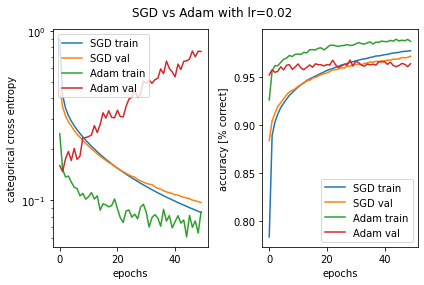

In [ ]:

def comparison_plot(history_sgd, history_adam, label1, label2, title):
    fig, ax1, ax2 = prepare_standardplot(title, "epochs")
    ax1.plot(history_sgd.history['loss'], label=label1 + ' train')
    ax1.plot(history_sgd.history['val_loss'], label=label1 + ' val')
    ax1.plot(history_adam.history['loss'], label=label2 + ' train')
    ax1.plot(history_adam.history['val_loss'], label=label2 + ' val')
    ax2.plot(history_sgd.history['accuracy'], label=label1 + ' train')
    ax2.plot(history_sgd.history['val_accuracy'], label=label1 + ' val')
    ax2.plot(history_adam.history['accuracy'], label=label2 + ' train')
    ax2.plot(history_adam.history['val_accuracy'], label=label2 + ' val')
    finalize_standardplot(fig, ax1, ax2)
    return fig

#Question 3-4: plot the learning curves of SGD and Adam
comparison_plot(history3_sgd_002, history_adam_002, 'SGD', 'Adam', 'SGD vs Adam with lr=0.02');

#### 3-6

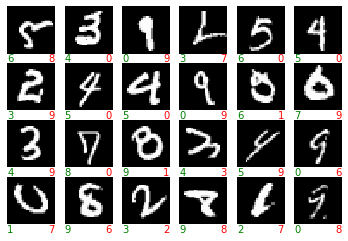

In [ ]:
#Question 3-6: 
pred = model_adam_002.predict(data_mnist_test)
y_hat_test = np.argmax(pred, axis=1)
y_truth = np.argmax(labels_mnist_test, axis=1)
err_indices = (y_hat_test != y_truth).nonzero()
plot_some_samples(data_mnist_test, labels_mnist_test, y_hat_test, err_indices[0]);

#### 3-7

In [ ]:
# Question 3-7:
np.random.seed(0)
tf.random.set_seed(0)

noisy=np.floor(np.random.uniform(0,10,size=12000)).astype(np.int)
noise_labels=np.copy(y_mnist_train)
print(noisy.shape)
idxs=np.random.choice(np.arange(y_mnist_train.shape[0]), size=int(y_mnist_train.shape[0]*0.2), replace=False)
print(idxs)
noise_labels[idxs]=noisy
labels_noise_mnist=to_categorical(noise_labels)


(12000,)
[44793 27956  4820 ... 21269 23837 16580]


In [ ]:
# Question 3-7:

np.random.seed(0)
tf.random.set_seed(0)

model = Sequential()
model.add(Dense(128, input_dim = 784, activation='relu'))
model.add(Dense(10, activation='softmax'))
adam = optimizers.Adam()
model.compile(optimizer=adam, loss = 'categorical_crossentropy', metrics = ['accuracy'])
historyNoise = model.fit(data_mnist_train, labels_noise_mnist, batch_size = 128, epochs = 100, validation_data=(data_mnist_test,labels_mnist_test), verbose=1)

Epoch 1/100
469/469 [==============================] - 3s 6ms/step - loss: 1.3211 - accuracy: 0.6754 - val_loss: 0.4260 - val_accuracy: 0.9376
Epoch 2/100
469/469 [==============================] - 2s 5ms/step - loss: 1.0501 - accuracy: 0.7771 - val_loss: 0.3621 - val_accuracy: 0.9573
Epoch 3/100
469/469 [==============================] - 2s 5ms/step - loss: 0.9943 - accuracy: 0.7879 - val_loss: 0.3306 - val_accuracy: 0.9638
Epoch 4/100
469/469 [==============================] - 2s 5ms/step - loss: 0.9640 - accuracy: 0.7941 - val_loss: 0.3656 - val_accuracy: 0.9624
Epoch 5/100
469/469 [==============================] - 2s 5ms/step - loss: 0.9537 - accuracy: 0.7956 - val_loss: 0.3374 - val_accuracy: 0.9639
Epoch 6/100
469/469 [==============================] - 2s 4ms/step - loss: 0.9325 - accuracy: 0.7992 - val_loss: 0.3275 - val_accuracy: 0.9661
Epoch 7/100
469/469 [==============================] - 2s 5ms/step - loss: 0.9120 - accuracy: 0.8015 - val_loss: 0.3129 - val_accuracy: 0.9680

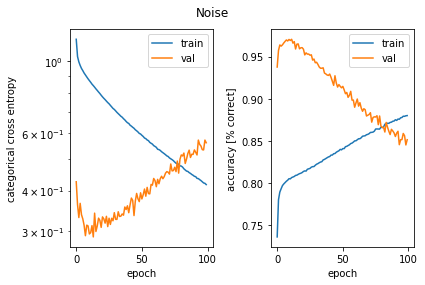

In [ ]:
# Question 3-7:
plot_history(historyNoise,'Noise');

## Exercise 4: Model performance as a function of number of hidden neurons (8 + 2 points)

Since the MNIST dataset is almost perfectly solved already by a one-hidden-layer network in Exercise 3, we use the Fashion-MNIST dataset from now on to compare the performances of more complex models. In this exercise, we investigate how the best validation loss and accuracy depends on the number of hidden neurons in a single layer.

1. Fit at least 4 models with different number of hidden neurons (i.e. width) between 10 and 1000 to the Fashion-MNIST dataset. Train with Adam for 50-100 epochs. (2 pts)
2. Plot the best validation loss and accuracy versus the width. Is the observed trend in accordance with the [general approximation theorem](https://en.wikipedia.org/wiki/Universal_approximation_theorem)? Do you observe an overfitting due to the complexity of the wider networks with more parameters? Report the best validation accuracy. (2 pts)
3. Choose $ p \geq 0.5 $ fraction of the data points from the training dataset of Fashion-MNIST and change their class labels randomly as in Exercise 3. For this noisy Fashion-MNIST dataset, fit at least 4 models with different widths between 10 and 250. Train with Adam for at least 150 epochs. Plot the best validation loss and accuracy vs. width. (2 pts)
4. BONUS: Add random Gaussian noise on the input pixels with mean 0 and variance between 0.01-0.5 and use the original labels. For this noisy Fashion-MNIST dataset, fit at least 4 models with different widths between 10 and 250. Train with Adam for at least 150 epochs. Plot the best validation loss and accuracy vs. width. (2 pts)
5. Answer to the same questions in 2 for the noisy Fashion-MNIST dataset(s). Comment on the differences between width-performence curves for these two (or three) datasets. (2 pts)

In this exercise we fit each model only for one initialization and random seed. In practice one would collect some statistics (e.g. 25-, 50-, 75-percentiles) for each layer size by fitting each model several times with different initializations and the random seeds. You may also want to do this here. It is a good exercise, but not mandatory as it takes quite a bit of computation time.

**Answer to Question 2** (max 2 sentences): 

The observed trend is in accordance with the general approximation theorem. 

We didn't observe an overfitting due to the complexity of the wider networks because validation loss don't increase as increasing number of neurons, and the best validation accuracy is 0.9016.

**Answer to Question 5** (max 3 sentences): 

The observed trend is in accordance with the general approximation theorem, and the best validation accuracy achieved is 0.8422 for the noisy label dataset, 0.8952 for the Gaussian noise input dataset. 

In the two noisy datasets, we observed an overfitting when number of neurons is greater than 50. 

Once the network is wide enough, data with Gaussian noise in input pixels almost can reach the same validation accuracy as the dataset without noise, but adding uniformly distributed noise on targets can decrease the validation accuracy a lot even with large width. 

### Solution

#### 4-1

In [ ]:
#Question 4-1: different number of hidden neurons for fashion-MNIST

np.random.seed(0)
tf.random.set_seed(0)

widths_mnist=[10, 50, 100, 250, 500, 1000]
histories_width_mnist = []
for w in widths_mnist:
    model4_mnist = Sequential()
    model4_mnist.add(Dense(w, input_dim = 784, activation='relu'))
    model4_mnist.add(Dense(10, activation='softmax'))
    model4_mnist.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    history_ex = model4_mnist.fit(data_fashion_train, labels_fashion_train, batch_size = 128, epochs = 50, validation_data=(data_fashion_test,labels_fashion_test), verbose=1)
    histories_width_mnist.append(history_ex)



Epoch 1/50
469/469 [==============================] - 2s 3ms/step - loss: 1.3436 - accuracy: 0.5274 - val_loss: 0.6187 - val_accuracy: 0.7788
Epoch 2/50
469/469 [==============================] - 1s 2ms/step - loss: 0.5583 - accuracy: 0.8064 - val_loss: 0.5249 - val_accuracy: 0.8195
Epoch 3/50
469/469 [==============================] - 1s 2ms/step - loss: 0.4878 - accuracy: 0.8354 - val_loss: 0.4878 - val_accuracy: 0.8313
Epoch 4/50
469/469 [==============================] - 1s 2ms/step - loss: 0.4558 - accuracy: 0.8443 - val_loss: 0.4690 - val_accuracy: 0.8372
Epoch 5/50
469/469 [==============================] - 1s 2ms/step - loss: 0.4331 - accuracy: 0.8513 - val_loss: 0.4590 - val_accuracy: 0.8417
Epoch 6/50
469/469 [==============================] - 1s 2ms/step - loss: 0.4214 - accuracy: 0.8559 - val_loss: 0.4634 - val_accuracy: 0.8381
Epoch 7/50
469/469 [==============================] - 1s 2ms/step - loss: 0.4083 - accuracy: 0.8596 - val_loss: 0.4598 - val_accuracy: 0.8400
Epoch 

In [ ]:
# print the best validation accuracy achieved.
a= max(history_ex.history['val_accuracy'])
print('The best validation accuracy is:', str(round(a, 4)))

The best validation accuracy is: 0.9016


#### 4-2

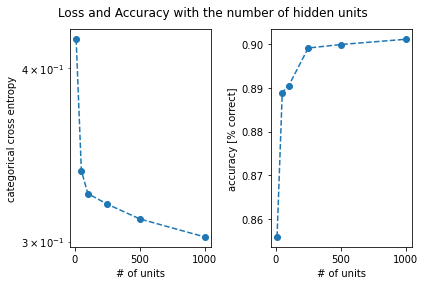

In [ ]:
#Question 4-2: plot the best validation loss and accuracy versus the width for fashion-mnist. 
def comparison_layer(histories,hidden_units, title):
    fig, ax1, ax2 = prepare_standardplot(title, "# of units")
    min_loss = [min(h.history['val_loss']) for h in histories]
    max_accuracy = [max(h.history['val_accuracy']) for h in histories]
    ax1.plot(hidden_units, min_loss, marker='o', linestyle='--')
    ax2.plot(hidden_units, max_accuracy, marker='o', linestyle='--')
    finalize_standardplot(fig, ax1, ax2)
    return fig

comparison_layer(histories_width_mnist, widths_mnist, 'Loss and Accuracy with the number of hidden units');

#### 4-3

In [ ]:
#Question 4-3: different number of hidden neurons for noisy fashion-MNIST
np.random.seed(0)
tf.random.set_seed(0)

idxs=np.random.choice(np.arange(y_fashion_train.shape[0]), size=int(0.7*y_fashion_train.shape[0]), replace=False)
noise_labels=np.copy(y_fashion_train)
noise_labels[idxs]=np.floor(np.random.uniform(0,10,size=int(0.7*y_fashion_train.shape[0]))).astype(np.int)
labels_noise_mnist=to_categorical(noise_labels)

widths_mnist_noisy=[10, 25, 50, 100, 150 ,200, 250]
histories_width_mnist_noisy = []
for w in widths_mnist_noisy:
    model43_mnist = Sequential()
    model43_mnist.add(Dense(w, input_dim = 784, activation='relu'))
    model43_mnist.add(Dense(10, activation='softmax'))
    model43_mnist.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    history_ey = model43_mnist.fit(data_fashion_train, labels_noise_mnist, batch_size = 128, epochs = 150, validation_data=(data_fashion_test,labels_fashion_test), verbose=1)
    histories_width_mnist_noisy.append(history_ey)


Epoch 1/150
469/469 [==============================] - 14s 3ms/step - loss: 2.2558 - accuracy: 0.1826 - val_loss: 1.7361 - val_accuracy: 0.6095
Epoch 2/150
469/469 [==============================] - 1s 2ms/step - loss: 2.1848 - accuracy: 0.2614 - val_loss: 1.6157 - val_accuracy: 0.7045
Epoch 3/150
469/469 [==============================] - 1s 2ms/step - loss: 2.1649 - accuracy: 0.2827 - val_loss: 1.5260 - val_accuracy: 0.7066
Epoch 4/150
469/469 [==============================] - 1s 2ms/step - loss: 2.1540 - accuracy: 0.2828 - val_loss: 1.5042 - val_accuracy: 0.7063
Epoch 5/150
469/469 [==============================] - 1s 2ms/step - loss: 2.1426 - accuracy: 0.2865 - val_loss: 1.5020 - val_accuracy: 0.7165
Epoch 6/150
469/469 [==============================] - 1s 2ms/step - loss: 2.1351 - accuracy: 0.2934 - val_loss: 1.5136 - val_accuracy: 0.7317
Epoch 7/150
469/469 [==============================] - 1s 2ms/step - loss: 2.1342 - accuracy: 0.2940 - val_loss: 1.4521 - val_accuracy: 0.737

In [ ]:
# print the best validation accuracy achieved.
a= [max(history.history['val_accuracy']) for history in histories_width_mnist_noisy]
print('The best validation accuracy is:', str(round(max(a), 4)))

The best validation accuracy is: 0.8422


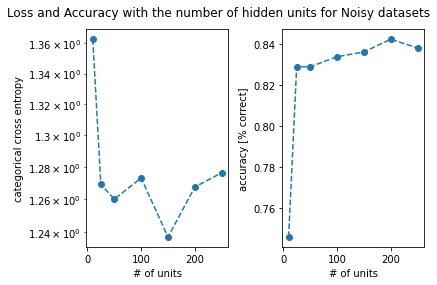

In [ ]:
##Question 4-3:  plot the best validation loss and accuracy versus the width for noisy fashion-mnist. 
def comparison_layer(histories,hidden_units, title):
    fig, ax1, ax2 = prepare_standardplot(title, "# of units")
    min_loss = [min(h.history['val_loss']) for h in histories]
    max_accuracy = [max(h.history['val_accuracy']) for h in histories]
    ax1.plot(hidden_units, min_loss, marker='o', linestyle='--')
    ax2.plot(hidden_units, max_accuracy, marker='o', linestyle='--')
    finalize_standardplot(fig, ax1, ax2)
    return fig
comparison_layer(histories_width_mnist_noisy, widths_mnist_noisy, 'Loss and Accuracy with the number of hidden units for Noisy datasets');

#### 4-4

Epoch 1/150
469/469 [==============================] - 2s 3ms/step - loss: 1.2727 - accuracy: 0.5512 - val_loss: 0.6084 - val_accuracy: 0.7924
Epoch 2/150
469/469 [==============================] - 1s 2ms/step - loss: 0.5590 - accuracy: 0.8095 - val_loss: 0.5275 - val_accuracy: 0.8213
Epoch 3/150
469/469 [==============================] - 1s 2ms/step - loss: 0.5003 - accuracy: 0.8289 - val_loss: 0.5011 - val_accuracy: 0.8289
Epoch 4/150
469/469 [==============================] - 1s 2ms/step - loss: 0.4774 - accuracy: 0.8347 - val_loss: 0.4933 - val_accuracy: 0.8291
Epoch 5/150
469/469 [==============================] - 1s 2ms/step - loss: 0.4589 - accuracy: 0.8389 - val_loss: 0.4765 - val_accuracy: 0.8359
Epoch 6/150
469/469 [==============================] - 1s 2ms/step - loss: 0.4453 - accuracy: 0.8459 - val_loss: 0.4661 - val_accuracy: 0.8382
Epoch 7/150
469/469 [==============================] - 1s 2ms/step - loss: 0.4358 - accuracy: 0.8482 - val_loss: 0.4676 - val_accuracy: 0.8364

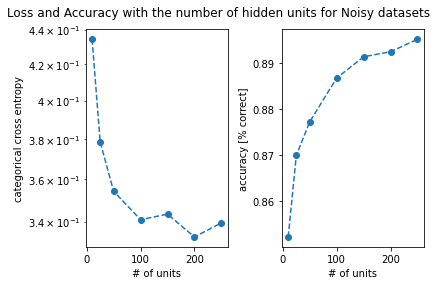

In [ ]:
#Question 4-4: Gaussian noise+ different number of hidden neurons for noisy fashion-MNIST
mu, sigma = 0, 0.1
noise_train = data_fashion_train + np.random.normal(mu, sigma, size = data_fashion_train.shape )
widths_mnist_noisy=[10, 25, 50, 100, 150 ,200, 250]
histories_width_mnist_noisyinput = []
for w in widths_mnist_noisy:
    model44_mnist = Sequential()
    model44_mnist.add(Dense(w, input_dim = 784, activation='relu'))
    model44_mnist.add(Dense(10, activation='softmax'))
    model44_mnist.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    history_ey = model44_mnist.fit(noise_train, labels_fashion_train, batch_size = 128, epochs = 150, validation_data=(data_fashion_test,labels_fashion_test), verbose=1)
    histories_width_mnist_noisyinput.append(history_ey)
  
 
#plot the best validation loss and accuracy versus the width for noisy fashion-mnist. 
comparison_layer(histories_width_mnist_noisyinput, widths_mnist_noisy, 'Loss and Accuracy with the number of hidden units for Noisy datasets');

In [ ]:
# print the best validation accuracy achieved.
a= [max(history.history['val_accuracy']) for history in histories_width_mnist_noisyinput]
print('The best validation accuracy is:', str(round(max(a), 4)))

The best validation accuracy is: 0.8952


## Exercise 5: Going deeper: tricks and regularization (10 + 2 points)

Adding hidden layers to a deep network does not necessarily lead to a straight-forward improvement of performance. We use Fashion-MNIST dataset in this exercise.  

1. Choose a width $ h $ between 50-200 and use at least two hidden layers with $ h $ hidden neurons (each) and train the network for at least 150 epochs. (2 pts)
2. Plot the learning curves and report the best validation accuracy. Do you observe overfitting? (2 pts)
3. Keep the network at the same size. Use a very large l2 regularization $\lambda$ (for ex. $\lambda=1$) and a small one (for ex. $\lambda=0.001$) on kernel weights and report the validation accuracies. What do you observe?  (2 pts)
4. Turn off the $ \ell_2 $ regularization and use a large dropout rate (for ex. 0.5) and a small one (for ex. 0.05) at all hidden layers and report the validation accuracies. What do you observe? (2 pts)
5. BONUS: Try built-in data augmentation methods as a way to regularize: this may include horizontal flipping of the images or small rotations. You can use built-in methods in Keras. Report the augmentation method you used and the best validation accuracy. (2 pts)

Note that one needs to cross-validate to find the right regularization parameter for the model you chose and for the dataset at hand. However we do not enforce this hyperparameter search as it takes long computation times but it is a good practice if you try it here. 

6. Compare the validation accuracies resulting from your attempts to reduce overfitting. Did you improve the validation accuracy? If not, comment on the possible sources of failure. (2 pts)

**Answer to Question 2** (max 1 sentence):

We observed an overfitting. The best validation accuracy is 0.8956.

**Answer to Question 3** (max 2 sentences): 

The best validation accuracy with $\lambda=1$ is 0.7052, the best validation accuracy with $\lambda=0.001$ is 0.8896. 

With large $\lambda=1$, we observed no overfitting but the validation accuracy drop a lot; with small $\lambda=0.001$, we observed no overfitting and the validation accuracy just falls a little bit.

**Answer to Question 4** (max 2 sentences): 

The best validation accuracy with dropout rate 0.05 is 0.8967, the best validation accuracy with dropout rate 0.5 is 0.8852. 

With small drop rate 0.05, we observed a high validation accuracy, but the overfitting problem is still there; with higher drop rate 0.5, we observed a slightly lower validation accuracy but we saw no clear overfitting trend.

**Answer to Question 5 (BONUS)** (max 2 sentences):

We flip the images horizontally with the build-in method ImageDataGenerator, and we get the best validation accuracy is 0.894

**Answer to Question 6** (max 2 sentences): 

Only with drop rate equal to 0.05, the validation rate has a slight 0.0011 improvement.

We didn't observe clear improvement might because the two hidden layers network is lack of complexity, so the regulators did not take siginificant effect on validation accuracy. 

### Solution

#### 5-1

In [ ]:
## exercise 5-1: basic desigh
np.random.seed(0)
tf.random.set_seed(0)

model_51 = Sequential()
model_51.add(Dense(100, input_dim = 784, activation='relu'))
model_51.add(Dense(100, activation='relu'))
model_51.add(Dense(10, activation='softmax'))
adam = optimizers.Adam(learning_rate = 0.001)
model_51.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics = ['accuracy'])
history = model_51.fit(data_fashion_train, labels_fashion_train, batch_size = 128, epochs = 200, validation_data=(data_fashion_test, labels_fashion_test), verbose=1)

Epoch 1/200
469/469 [==============================] - 2s 4ms/step - loss: 0.7564 - accuracy: 0.7413 - val_loss: 0.4377 - val_accuracy: 0.8427
Epoch 2/200
469/469 [==============================] - 1s 3ms/step - loss: 0.3963 - accuracy: 0.8563 - val_loss: 0.3963 - val_accuracy: 0.8598
Epoch 3/200
469/469 [==============================] - 2s 3ms/step - loss: 0.3541 - accuracy: 0.8716 - val_loss: 0.3834 - val_accuracy: 0.8631
Epoch 4/200
469/469 [==============================] - 1s 3ms/step - loss: 0.3212 - accuracy: 0.8840 - val_loss: 0.3711 - val_accuracy: 0.8646
Epoch 5/200
469/469 [==============================] - 1s 3ms/step - loss: 0.3037 - accuracy: 0.8886 - val_loss: 0.3493 - val_accuracy: 0.8740
Epoch 6/200
469/469 [==============================] - 1s 3ms/step - loss: 0.2877 - accuracy: 0.8978 - val_loss: 0.3558 - val_accuracy: 0.8706
Epoch 7/200
469/469 [==============================] - 1s 3ms/step - loss: 0.2744 - accuracy: 0.8990 - val_loss: 0.3546 - val_accuracy: 0.8725

In [ ]:
# print the best validation accuracy achieved.
a= max(history.history['val_accuracy']) 
print('The best validation accuracy is:', str(round(a, 4)))

The best validation accuracy is: 0.8956


#### 5-2

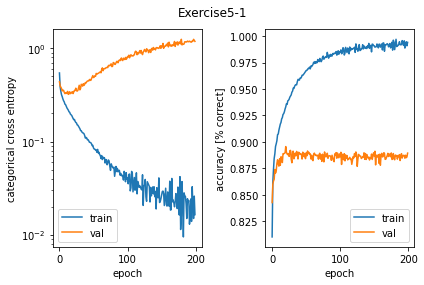

In [ ]:
## exercise 5-2: Plot the learning curves
plot_history(history,'Exercise5-1');

#### 5-3

In [ ]:
## exercise 5-3 use l2 : 1
np.random.seed(0)
tf.random.set_seed(0)

model_53_1 = Sequential()
model_53_1.add(Dense(100, input_dim = 784, activation='relu', kernel_regularizer= regularizers.l2(1)))
model_53_1.add(Dense(100, activation='relu', kernel_regularizer= regularizers.l2(1)))
model_53_1.add(Dense(10, activation='softmax'))
adam = optimizers.Adam(lr = 0.001)
model_53_1.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics = ['accuracy'])
history53_1 = model_53_1.fit(data_fashion_train, labels_fashion_train, batch_size = 128, epochs = 200, validation_data=(data_fashion_test, labels_fashion_test), verbose=1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/200
469/469 [==============================] - 2s 4ms/step - loss: 65.7581 - accuracy: 0.4055 - val_loss: 2.0092 - val_accuracy: 0.4362
Epoch 2/200
469/469 [==============================] - 2s 3ms/step - loss: 1.9453 - accuracy: 0.4740 - val_loss: 1.8020 - val_accuracy: 0.5099
Epoch 3/200
469/469 [==============================] - 2s 3ms/step - loss: 1.7807 - accuracy: 0.5138 - val_loss: 1.7018 - val_accuracy: 0.5244
Epoch 4/200
469/469 [==============================] - 2s 3ms/step - loss: 1.6916 - accuracy: 0.5306 - val_loss: 1.6437 - val_accuracy: 0.5350
Epoch 5/200
469/469 [==============================] - 2s 3ms/step - loss: 1.6371 - accuracy: 0.5427 - val_loss: 1.5971 - val_accuracy: 0.5668
Epoch 6/200
469/469 [==============================] - 2s 3ms/step - loss: 1.5922 - accuracy: 0.5640 - val_loss: 1.5534 - val_accuracy: 0.5562
Epoch 7/200
469/469 [==============================] - 2s 3ms/step - loss: 1.5519 - accuracy: 0.5696 - val_loss: 1.5231 - val_accuracy: 0.586

In [ ]:
# print the best validation accuracy achieved.
a= max(history53_1.history['val_accuracy']) 
print('The best validation accuracy is:', str(round(a, 4)))

The best validation accuracy is: 0.7052


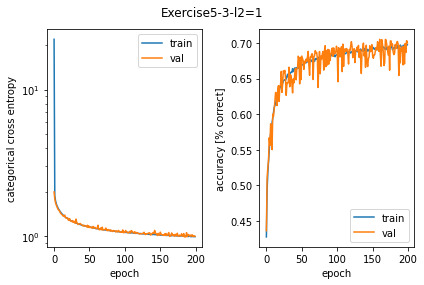

In [ ]:
plot_history(history53_1,"Exercise5-3-l2=1");

In [ ]:
## exercise 5-3 use l2 : 0.001
np.random.seed(0)
tf.random.set_seed(0)
model_53_2 = Sequential()
model_53_2 .add(Dense(100, input_dim = 784, activation='relu', kernel_regularizer= regularizers.l2(0.001)))
model_53_2 .add(Dense(100, activation='relu', kernel_regularizer= regularizers.l2(0.001)))
model_53_2 .add(Dense(10, activation='softmax'))
adam = optimizers.Adam(lr = 0.001)
model_53_2 .compile(optimizer = adam, loss = 'categorical_crossentropy', metrics = ['accuracy'])
history53_2 = model_53_2.fit(data_fashion_train, labels_fashion_train, batch_size = 128, epochs = 200, validation_data=(data_fashion_test, labels_fashion_test), verbose=1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/200
469/469 [==============================] - 3s 4ms/step - loss: 0.9840 - accuracy: 0.7395 - val_loss: 0.6204 - val_accuracy: 0.8369
Epoch 2/200
469/469 [==============================] - 2s 4ms/step - loss: 0.5731 - accuracy: 0.8505 - val_loss: 0.5455 - val_accuracy: 0.8555
Epoch 3/200
469/469 [==============================] - 2s 3ms/step - loss: 0.5190 - accuracy: 0.8622 - val_loss: 0.5205 - val_accuracy: 0.8566
Epoch 4/200
469/469 [==============================] - 2s 3ms/step - loss: 0.4839 - accuracy: 0.8686 - val_loss: 0.5072 - val_accuracy: 0.8570
Epoch 5/200
469/469 [==============================] - 2s 3ms/step - loss: 0.4549 - accuracy: 0.8745 - val_loss: 0.5129 - val_accuracy: 0.8508
Epoch 6/200
469/469 [==============================] - 2s 4ms/step - loss: 0.4416 - accuracy: 0.8781 - val_loss: 0.4814 - val_accuracy: 0.8616
Epoch 7/200
469/469 [==============================] - 2s 4ms/step - loss: 0.4283 - accuracy: 0.8804 - val_loss: 0.4647 - val_accuracy: 0.8663

In [ ]:
# print the best validation accuracy achieved.
a= max(history53_2.history['val_accuracy']) 
print('The best validation accuracy is:', str(round(a, 4)))

The best validation accuracy is: 0.8896


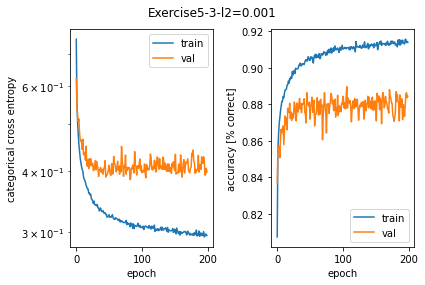

In [ ]:
plot_history(history53_2, 'Exercise5-3-l2=0.001');

#### 5-4

In [ ]:
##exercise 5-4 use drop out 0.05
np.random.seed(0)
tf.random.set_seed(0)
model_54_1 = Sequential()
model_54_1.add(Dense(100, input_dim = 784, activation='relu'))
model_54_1.add(Dropout(rate=0.05))
model_54_1.add(Dense(100, activation='relu'))
model_54_1.add(Dropout(rate=0.05))
model_54_1.add(Dense(10, activation='softmax'))
adam = optimizers.Adam(lr = 0.001)
model_54_1.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics = ['accuracy'])
history54_1 = model_54_1.fit(data_fashion_train, labels_fashion_train, batch_size = 128, epochs = 200, validation_data=(data_fashion_test, labels_fashion_test), verbose=1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/200
469/469 [==============================] - 3s 4ms/step - loss: 0.7996 - accuracy: 0.7257 - val_loss: 0.4354 - val_accuracy: 0.8477
Epoch 2/200
469/469 [==============================] - 2s 4ms/step - loss: 0.4116 - accuracy: 0.8508 - val_loss: 0.3902 - val_accuracy: 0.8616
Epoch 3/200
469/469 [==============================] - 2s 4ms/step - loss: 0.3637 - accuracy: 0.8679 - val_loss: 0.3661 - val_accuracy: 0.8672
Epoch 4/200
469/469 [==============================] - 2s 3ms/step - loss: 0.3383 - accuracy: 0.8780 - val_loss: 0.3635 - val_accuracy: 0.8690
Epoch 5/200
469/469 [==============================] - 2s 4ms/step - loss: 0.3176 - accuracy: 0.8828 - val_loss: 0.3494 - val_accuracy: 0.8731
Epoch 6/200
469/469 [==============================] - 2s 4ms/step - loss: 0.3061 - accuracy: 0.8906 - val_loss: 0.3451 - val_accuracy: 0.8734
Epoch 7/200
469/469 [==============================] - 2s 3ms/step - loss: 0.2877 - accuracy: 0.8944 - val_loss: 0.3395 - val_accuracy: 0.8784

In [ ]:
# print the best validation accuracy achieved.
a= max(history54_1.history['val_accuracy']) 
print('The best validation accuracy is:', str(round(a, 4)))

The best validation accuracy is: 0.8967


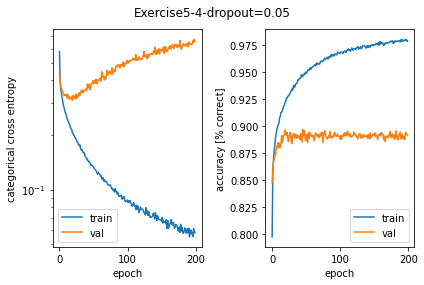

In [ ]:
plot_history(history54_1, 'Exercise5-4-dropout=0.05');

In [ ]:
##exercise 5-4 use drop out 0.5
np.random.seed(0)
tf.random.set_seed(0)
model_54_2 = Sequential()
model_54_2.add(Dense(100, input_dim = 784, activation='relu'))
model_54_2.add(Dropout(rate=0.5))
model_54_2.add(Dense(100, activation='relu'))
model_54_2.add(Dropout(rate=0.5))
model_54_2.add(Dense(10, activation='softmax'))
adam = optimizers.Adam(lr = 0.001)
model_54_2.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics = ['accuracy'])
history54_2 = model_54_2.fit(data_fashion_train, labels_fashion_train, batch_size = 128, epochs = 200, validation_data=(data_fashion_test, labels_fashion_test), verbose=1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/200
469/469 [==============================] - 3s 4ms/step - loss: 1.2145 - accuracy: 0.5635 - val_loss: 0.5137 - val_accuracy: 0.8063
Epoch 2/200
469/469 [==============================] - 2s 4ms/step - loss: 0.6100 - accuracy: 0.7841 - val_loss: 0.4510 - val_accuracy: 0.8362
Epoch 3/200
469/469 [==============================] - 2s 4ms/step - loss: 0.5357 - accuracy: 0.8111 - val_loss: 0.4374 - val_accuracy: 0.8438
Epoch 4/200
469/469 [==============================] - 2s 4ms/step - loss: 0.5081 - accuracy: 0.8181 - val_loss: 0.4156 - val_accuracy: 0.8513
Epoch 5/200
469/469 [==============================] - 2s 4ms/step - loss: 0.4820 - accuracy: 0.8290 - val_loss: 0.4125 - val_accuracy: 0.8522
Epoch 6/200
469/469 [==============================] - 2s 4ms/step - loss: 0.4708 - accuracy: 0.8333 - val_loss: 0.4089 - val_accuracy: 0.8504
Epoch 7/200
469/469 [==============================] - 2s 3ms/step - loss: 0.4509 - accuracy: 0.8396 - val_loss: 0.3970 - val_accuracy: 0.8616

In [ ]:
# print the best validation accuracy achieved.
a= max(history54_2.history['val_accuracy']) 
print('The best validation accuracy is:', str(round(a, 4)))

The best validation accuracy is: 0.8852


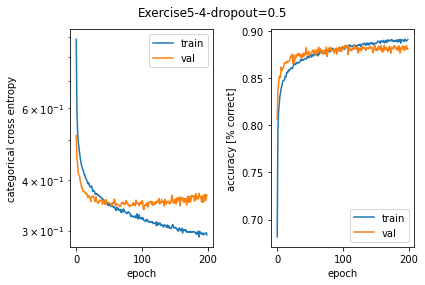

In [ ]:
plot_history(history54_2, 'Exercise5-4-dropout=0.5');

#### 5-5

In [13]:
## exercise 5-5 data augmentation: horizontal_flip
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
horizontal_flip=True
)
train_aug=np.expand_dims(x_fashion_train,axis=3)
train_aug=normalization(train_aug)

val_aug=np.expand_dims(x_fashion_test,axis=3)
val_aug=normalization(val_aug)

val_datagen=ImageDataGenerator()

datagen.fit(train_aug)
val_datagen.fit(val_aug)
train_generator = datagen.flow(train_aug, labels_fashion_train, batch_size=128)
val_generator=val_datagen.flow(val_aug,labels_fashion_test,batch_size=128)
model_552 = Sequential()
model_552.add(Flatten())
model_552.add(Dense(100, input_dim = 784, activation='relu'))
model_552.add(Dense(100, activation='relu'))
model_552.add(Dense(10, activation='softmax'))
model_552.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
history_55a=model_552.fit_generator(generator=train_generator, validation_data=val_generator, 
                                    epochs=200,verbose=1)


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/200
469/469 [==============================] - 4s 6ms/step - loss: 0.8184 - accuracy: 0.7228 - val_loss: 0.4495 - val_accuracy: 0.8413
Epoch 2/200
469/469 [==============================] - 3s 6ms/step - loss: 0.4188 - accuracy: 0.8513 - val_loss: 0.4472 - val_accuracy: 0.8417
Epoch 3/200
469/469 [==============================] - 3s 5ms/step - loss: 0.3747 - accuracy: 0.8620 - val_loss: 0.3867 - val_accuracy: 0.8594
Epoch 4/200
469/469 [==============================] - 3s 5ms/step - loss: 0.3460 - accuracy: 0.8747 - val_loss: 0.3744 - val_accuracy: 0.8652
Epoch 5/200
469/469 [==============================] - 3s 6ms/step - loss: 0.3341 - accuracy: 0.8780 - val_loss: 0.4006 - val_accuracy: 0.8539
Epoch 6/200
469/469 [==============================] - 2s 5ms/step - loss: 0.3200 - accuracy: 0.8811 - val_loss: 0.3608 - val_accuracy: 0.8694
Epoch 7/200
469/469 [==============================] - 3s 5ms/step - loss: 0.2974 - accuracy: 0.8904 - val_loss: 0.3566 - val_accuracy: 0.8713

In [15]:
# print the best validation accuracy achieved.
a= max(history_55a.history['val_accuracy']) 
print('The best validation accuracy is:', str(round(a, 4)))

The best validation accuracy is: 0.894


## Exercise 6: Convolutional neural networks (CNNs) (10 points)

Convolutional neural networks have an inductive bias that is well adapted to image classification. 

1. Design a convolutional neural network and train it without using explicit regularizers. (2 pts)
2. Try to improve the best validation scores of the model by experiment with batch_normalization layers, dropout layers and l2-regularization on weights (kernels) and biases. (4 pts)
3. After you have found good settings, plot the learning curves for both models, naive (=no tricks/regularization) and tuned (=tricks + regularized) together in a comparison plot. (2pts)
4. How does the CNN performance compare to the so far best performing (deep) neural network model? (2 pts)

*Hint:* You may get valuable inspiration from the keras [examples](https://keras.io/examples/), [for example](https://keras.io/examples/vision/mnist_convnet/).

**Answer to Question 4**: 

CNN(with less epoches compare to the MLP) can obtain a higher validation accuracy compare to the so far best performing of MLP, but it takes a long time to run. The best validation we achieved is 0.9209 with CNN(dropout, batch normalization).

### Solution

#### 6-1

In [ ]:
# Question 6-1: Firstly, we design a simple convolutional neural network with convolution layers, maxpooling layers and linear layers.
np.random.seed(0)
tf.random.set_seed(0)

# We need to reshape the data to fit for the CNN.
CNNs_data_fashion_train=normalization(np.expand_dims(x_fashion_train, -1))
CNNs_data_fashion_test=normalization(np.expand_dims(x_fashion_test, -1))

# establish the model
model_61 = Sequential()
model_61.add(Conv2D(32, kernel_size=(3, 3),activation='relu',input_shape=(28,28,1)))
model_61.add(MaxPooling2D(pool_size=(2, 2)))
model_61.add(Conv2D(64, (3, 3), activation='relu'))
model_61.add(MaxPooling2D(pool_size=(2, 2)))
model_61.add(Flatten())
model_61.add(Dense(128, activation='relu'))
model_61.add(Dense(10, activation='softmax'))

model_61.compile(optimizer = "adam", loss = 'categorical_crossentropy', metrics = ['accuracy'])
hist_61 = model_61.fit(CNNs_data_fashion_train, labels_fashion_train, batch_size=128, epochs=20, verbose=1, validation_data=(CNNs_data_fashion_test, labels_fashion_test))

Epoch 1/20
469/469 [==============================] - 41s 86ms/step - loss: 0.7987 - accuracy: 0.7256 - val_loss: 0.3911 - val_accuracy: 0.8609
Epoch 2/20
469/469 [==============================] - 40s 85ms/step - loss: 0.3635 - accuracy: 0.8688 - val_loss: 0.3323 - val_accuracy: 0.8779
Epoch 3/20
469/469 [==============================] - 40s 85ms/step - loss: 0.3122 - accuracy: 0.8882 - val_loss: 0.3140 - val_accuracy: 0.8889
Epoch 4/20
469/469 [==============================] - 39s 83ms/step - loss: 0.2795 - accuracy: 0.8985 - val_loss: 0.3055 - val_accuracy: 0.8867
Epoch 5/20
469/469 [==============================] - 39s 83ms/step - loss: 0.2531 - accuracy: 0.9073 - val_loss: 0.2925 - val_accuracy: 0.8941
Epoch 6/20
469/469 [==============================] - 39s 83ms/step - loss: 0.2371 - accuracy: 0.9133 - val_loss: 0.2631 - val_accuracy: 0.9046
Epoch 7/20
469/469 [==============================] - 39s 83ms/step - loss: 0.2158 - accuracy: 0.9204 - val_loss: 0.2561 - val_accuracy:

In [ ]:
# print the best validation accuracy achieved.
a= max(hist_61.history['val_accuracy']) 
print('The best validation accuracy is:', str(round(a, 4)))

The best validation accuracy is: 0.917


#### 6-2

In [ ]:
#Question 6-2: We tried 3 models to add the normalization layers, dropout layers and l2-regularization to improve the validation scores.

np.random.seed(0)
tf.random.set_seed(0)

CNNs_data_fashion_train=normalization(np.expand_dims(x_fashion_train, -1))
CNNs_data_fashion_test=normalization(np.expand_dims(x_fashion_test, -1))

model_62a = Sequential()
model_62a.add(Conv2D(32, kernel_size=(3, 3),activation='relu',input_shape=(28,28,1)))
model_62a.add(BatchNormalization())
model_62a.add(Activation('relu'))
model_62a.add(MaxPooling2D(pool_size=(2, 2)))
model_62a.add(Dropout(0.2))
model_62a.add(Conv2D(64, (3, 3)))
model_62a.add(BatchNormalization())
model_62a.add(Activation('relu'))
model_62a.add(MaxPooling2D(pool_size=(2, 2)))
model_62a.add(Dropout(0.2))
model_62a.add(Flatten())
model_62a.add(Dense(128, activation='relu'))
model_62a.add(Dense(10, activation='softmax'))

model_62a.compile(optimizer = "adam", loss = 'categorical_crossentropy', metrics = ['accuracy'])
hist_attempt_1 = model_62a.fit(CNNs_data_fashion_train, labels_fashion_train,batch_size=128, epochs=20, verbose=1,  validation_data=(CNNs_data_fashion_test, labels_fashion_test))

Epoch 1/20
469/469 [==============================] - 61s 129ms/step - loss: 0.6953 - accuracy: 0.7546 - val_loss: 0.6284 - val_accuracy: 0.7669
Epoch 2/20
469/469 [==============================] - 60s 128ms/step - loss: 0.3477 - accuracy: 0.8713 - val_loss: 0.3176 - val_accuracy: 0.8826
Epoch 3/20
469/469 [==============================] - 61s 130ms/step - loss: 0.3090 - accuracy: 0.8865 - val_loss: 0.3080 - val_accuracy: 0.8859
Epoch 4/20
469/469 [==============================] - 60s 128ms/step - loss: 0.2780 - accuracy: 0.8976 - val_loss: 0.2886 - val_accuracy: 0.8970
Epoch 5/20
469/469 [==============================] - 60s 128ms/step - loss: 0.2597 - accuracy: 0.9017 - val_loss: 0.2720 - val_accuracy: 0.9013
Epoch 6/20
469/469 [==============================] - 61s 130ms/step - loss: 0.2477 - accuracy: 0.9085 - val_loss: 0.2668 - val_accuracy: 0.9036
Epoch 7/20
469/469 [==============================] - 60s 127ms/step - loss: 0.2330 - accuracy: 0.9126 - val_loss: 0.2662 - val_ac

In [ ]:
# print the best validation accuracy achieved.
a= max(hist_attempt_1.history['val_accuracy']) 
print('The best validation accuracy is:', str(round(a, 4)))

The best validation accuracy is: 0.9209


In [ ]:

np.random.seed(0)
tf.random.set_seed(0)

CNNs_data_fashion_train=normalization(np.expand_dims(x_fashion_train, -1))
CNNs_data_fashion_test=normalization(np.expand_dims(x_fashion_test, -1))

model_62b = Sequential()
model_62b.add(Conv2D(32, kernel_size=(3, 3),activation='relu',input_shape=(28,28,1)))
model_62b.add(BatchNormalization())
model_62b.add(Activation('relu'))
model_62b.add(MaxPooling2D(pool_size=(2, 2)))
model_62b.add(Dropout(0.5))
model_62b.add(Conv2D(64, (3, 3)))
model_62b.add(BatchNormalization())
model_62b.add(Activation('relu'))
model_62b.add(MaxPooling2D(pool_size=(2, 2)))
model_62b.add(Dropout(0.5))
model_62b.add(Flatten())
model_62b.add(Dense(128, activation='relu', kernel_regularizer= regularizers.l2(0.5)))
model_62b.add(Dense(10, activation='softmax'))

model_62b.compile(optimizer = "adam", loss = 'categorical_crossentropy', metrics = ['accuracy'])
hist_attempt_2 = model_62b.fit(CNNs_data_fashion_train, labels_fashion_train,batch_size=128, epochs=20, verbose=1,  validation_data=(CNNs_data_fashion_test, labels_fashion_test))


Epoch 1/20
469/469 [==============================] - 60s 125ms/step - loss: 18.7598 - accuracy: 0.6411 - val_loss: 1.3930 - val_accuracy: 0.7797
Epoch 2/20
469/469 [==============================] - 58s 124ms/step - loss: 0.9589 - accuracy: 0.7688 - val_loss: 0.9055 - val_accuracy: 0.8101
Epoch 3/20
469/469 [==============================] - 58s 123ms/step - loss: 0.9180 - accuracy: 0.7802 - val_loss: 0.8537 - val_accuracy: 0.8130
Epoch 4/20
469/469 [==============================] - 58s 123ms/step - loss: 0.8836 - accuracy: 0.7947 - val_loss: 0.8320 - val_accuracy: 0.8123
Epoch 5/20
469/469 [==============================] - 58s 123ms/step - loss: 0.8732 - accuracy: 0.7972 - val_loss: 0.8031 - val_accuracy: 0.8171
Epoch 6/20
469/469 [==============================] - 58s 123ms/step - loss: 0.8385 - accuracy: 0.8064 - val_loss: 0.7721 - val_accuracy: 0.8325
Epoch 7/20
469/469 [==============================] - 57s 122ms/step - loss: 0.8163 - accuracy: 0.8091 - val_loss: 0.7689 - val_a

In [ ]:
# print the best validation accuracy achieved.
a= max(hist_attempt_2.history['val_accuracy']) 
print('The best validation accuracy is:', str(round(a, 4)))

The best validation accuracy is: 0.8603


In [ ]:
np.random.seed(0)
tf.random.set_seed(0)

CNNs_data_fashion_train=normalization(np.expand_dims(x_fashion_train, -1))
CNNs_data_fashion_test=normalization(np.expand_dims(x_fashion_test, -1))

model_62c = Sequential()
model_62c.add(Conv2D(32, kernel_size=(3, 3),activation='relu',input_shape=(28,28,1), kernel_regularizer= regularizers.l2(0.001)))
model_62c.add(BatchNormalization())
model_62c.add(Activation('relu'))
model_62c.add(MaxPooling2D(pool_size=(2, 2)))
model_62c.add(Dropout(0.5))
model_62c.add(Conv2D(64, (3, 3)))
model_62c.add(BatchNormalization())
model_62c.add(Activation('relu'))
model_62c.add(MaxPooling2D(pool_size=(2, 2)))
model_62c.add(Dropout(0.5))
model_62c.add(Flatten())
model_62c.add(Dense(128, activation='relu'))
model_62c.add(Dense(10, activation='softmax'))

model_62c.compile(optimizer = "adam", loss = 'categorical_crossentropy', metrics = ['accuracy'])
hist_attempt_3 = model_62c.fit(CNNs_data_fashion_train, labels_fashion_train,batch_size=128, epochs=20, verbose=1,  validation_data=(CNNs_data_fashion_test, labels_fashion_test))

Epoch 1/20
469/469 [==============================] - 59s 124ms/step - loss: 0.9341 - accuracy: 0.6781 - val_loss: 0.6993 - val_accuracy: 0.7610
Epoch 2/20
469/469 [==============================] - 58s 123ms/step - loss: 0.4599 - accuracy: 0.8305 - val_loss: 0.3642 - val_accuracy: 0.8711
Epoch 3/20
469/469 [==============================] - 58s 124ms/step - loss: 0.3977 - accuracy: 0.8545 - val_loss: 0.3448 - val_accuracy: 0.8729
Epoch 4/20
469/469 [==============================] - 58s 123ms/step - loss: 0.3718 - accuracy: 0.8640 - val_loss: 0.3185 - val_accuracy: 0.8820
Epoch 5/20
469/469 [==============================] - 57s 122ms/step - loss: 0.3482 - accuracy: 0.8704 - val_loss: 0.3091 - val_accuracy: 0.8853
Epoch 6/20
469/469 [==============================] - 57s 122ms/step - loss: 0.3359 - accuracy: 0.8765 - val_loss: 0.3021 - val_accuracy: 0.8903
Epoch 7/20
469/469 [==============================] - 58s 123ms/step - loss: 0.3209 - accuracy: 0.8811 - val_loss: 0.2893 - val_ac

In [ ]:
# print the best validation accuracy achieved.
a= max(hist_attempt_3.history['val_accuracy']) 
print('The best validation accuracy is:', str(round(a, 4)))

The best validation accuracy is: 0.9095


#### 6-3

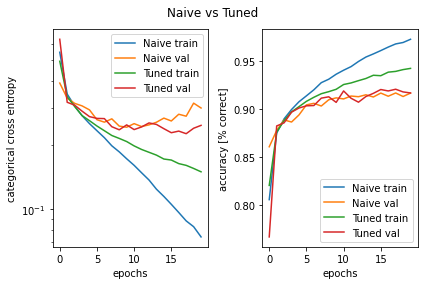

In [ ]:
# Question 6-3: plot the learning curves for both models
def comparison_plot(history_naive, history_tuned, label1, label2, title):
    fig, ax1, ax2 = prepare_standardplot(title, "epochs")
    ax1.plot(history_naive.history['loss'], label=label1 + ' train')
    ax1.plot(history_naive.history['val_loss'], label=label1 + ' val')
    ax1.plot(history_tuned.history['loss'], label=label2 + ' train')
    ax1.plot(history_tuned.history['val_loss'], label=label2 + ' val')
    ax2.plot(history_naive.history['accuracy'], label=label1 + ' train')
    ax2.plot(history_naive.history['val_accuracy'], label=label1 + ' val')
    ax2.plot(history_tuned.history['accuracy'], label=label2 + ' train')
    ax2.plot(history_tuned.history['val_accuracy'], label=label2 + ' val')
    finalize_standardplot(fig, ax1, ax2)
    return fig

#Question 3-4: plot the learning curves of SGD and Adam
comparison_plot(hist_61, hist_attempt_1, 'Naive', 'Tuned', 'Naive vs Tuned');